In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [3]:
df = pd.read_csv('penalties.csv', index_col=0)

In [4]:
df

,shot.end_location.y,shot.end_location.z,shot.outcome.name
1,36.2,0.3,Goal
2,43.8,1.4,Goal
3,42.0,0.2,Goal
4,38.3,1.3,Saved
5,36.4,0.5,Goal
...,...,...,...
269,36.6,2.0,Goal
270,37.9,1.3,Goal
271,43.4,2.4,Goal
272,36.6,2.0,Goal


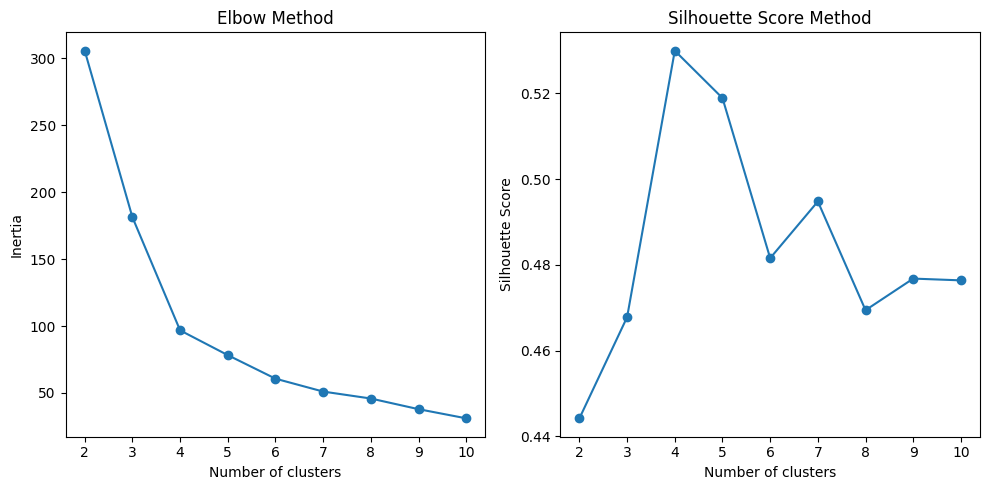

<Figure size 640x480 with 0 Axes>

In [9]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['shot.end_location.y', 'shot.end_location.z']])

max_clusters = 10
inertias = []
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_clusters + 1), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')

plt.tight_layout()
plt.show()
plt.savefig('cluster_metrics.png')

In [6]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(df_scaled)

df_scaled_clusteres = df.copy()
df_scaled_clusteres['Cluster'] = cluster_labels

cluster_centers_scaled = kmeans.cluster_centers_
cluster_centers_unscaled = scaler.inverse_transform(cluster_centers_scaled)

def distance_to_center(row, centers):
    point = row[['shot.end_location.y', 'shot.end_location.z']].values
    distances = np.sqrt(((point - centers) ** 2).sum(axis=1))
    return distances.min()

df_scaled_clusteres.to_csv('all_shots_clustered.csv', index=False)

In [7]:
print("\nSummary Statistics:")
print(df_scaled_clusteres.groupby('Cluster').agg({
    'shot.end_location.y': ['mean', 'min', 'max'],
    'shot.end_location.z': ['mean', 'min', 'max']
}))

print("\nCluster Centers (Unscaled):")
for i, center in enumerate(cluster_centers_unscaled):
    print(f"Cluster {i}: Y = {center[0]:.2f}, Z = {center[1]:.2f}")


Summary Statistics:
        shot.end_location.y             shot.end_location.z          
                       mean   min   max                mean  min  max
Cluster                                                              
0                 42.442466  40.1  43.8            0.410959  0.0  1.0
1                 37.385393  36.1  39.8            0.413483  0.0  0.9
2                 37.450000  36.2  40.0            1.566129  1.0  2.4
3                 42.612245  40.1  43.8            1.697959  1.1  2.5

Cluster Centers (Unscaled):
Cluster 0: Y = 42.44, Z = 0.41
Cluster 1: Y = 37.39, Z = 0.41
Cluster 2: Y = 37.45, Z = 1.57
Cluster 3: Y = 42.61, Z = 1.70


In [8]:
# 6. Calculate save percentages for each cluster
df['Cluster'] = kmeans.predict(scaler.transform(df[['shot.end_location.y', 'shot.end_location.z']]))

cluster_stats = df.groupby('Cluster').agg({
    'shot.outcome.name': lambda x: (x == 'Saved').mean()
}).rename(columns={'shot.outcome.name': 'Save_Percentage'})

print("Cluster Statistics:")
print(cluster_stats)

Cluster Statistics:
         Save_Percentage
Cluster                 
0               0.315068
1               0.247191
2               0.209677
3               0.061224
